## **Import library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")
import datetime

from sklearn import preprocessing
from sklearn.decomposition import PCA
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

## **Load dataset**

In [2]:
!gdown --id 1Dc6sB-74RuxG163jAyBsvYN6UTSVXEU5

Downloading...
From: https://drive.google.com/uc?id=1Dc6sB-74RuxG163jAyBsvYN6UTSVXEU5
To: /content/nyc_taxi.csv
100% 266k/266k [00:00<00:00, 31.8MB/s]


In [3]:
df = pd.read_csv('nyc_taxi.csv')

## **Understand data**

In [4]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [5]:
df.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB
None


## **Data Visualization**

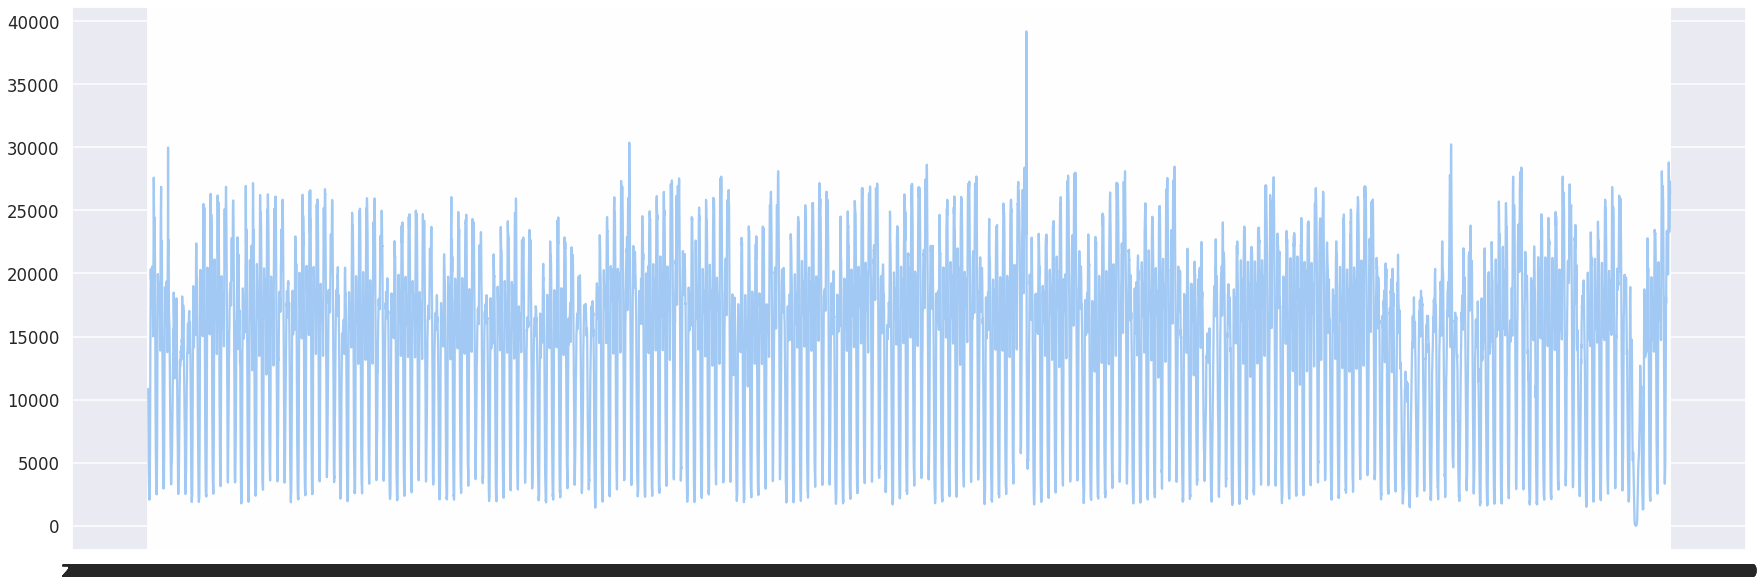

In [8]:
# plot the data
plt.figure(figsize=(30, 10))
plt.plot(df['timestamp'], df['value'])
plt.show()

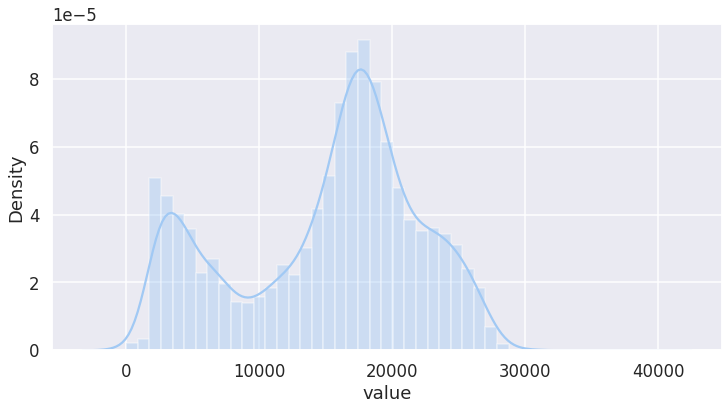

In [9]:
plt.figure(figsize = (12,6))
sns.distplot(df['value'])

## **Z-Score**

In [10]:
def out_zscore(data):
  global anomalies,zscores
  anomalies = []
  zscores = []
  numOfOutliers = 0
  threshold = 2
  mean = np.mean(data)
  std = np.std(data)
  for i in data:
    z_score = (i - mean)/std 
    zscores.append(z_score)
    if np.abs(z_score) > threshold:
      anomalies.append(1)
      numOfOutliers += 1
    else:
      anomalies.append(0)
  return print("Total number of outliers are",numOfOutliers)

In [11]:
out_zscore(df['value'].values)

Total number of outliers are 28


In [12]:
df['anomaly_zscore'] = anomalies

In [13]:
df.head()

,timestamp,value,anomaly_zscore
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


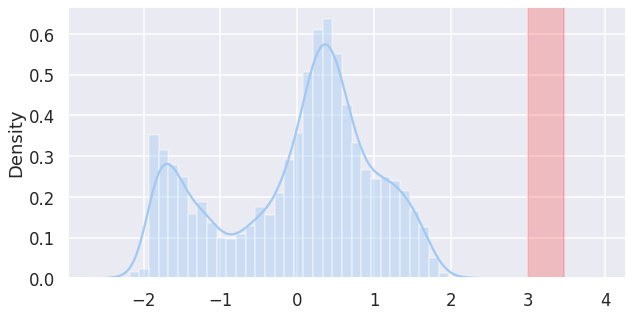

In [14]:
plt.figure(figsize = (10,5))
sns.distplot(zscores)
plt.axvspan(xmin = 3 ,xmax = max(zscores),alpha=0.2, color='red')

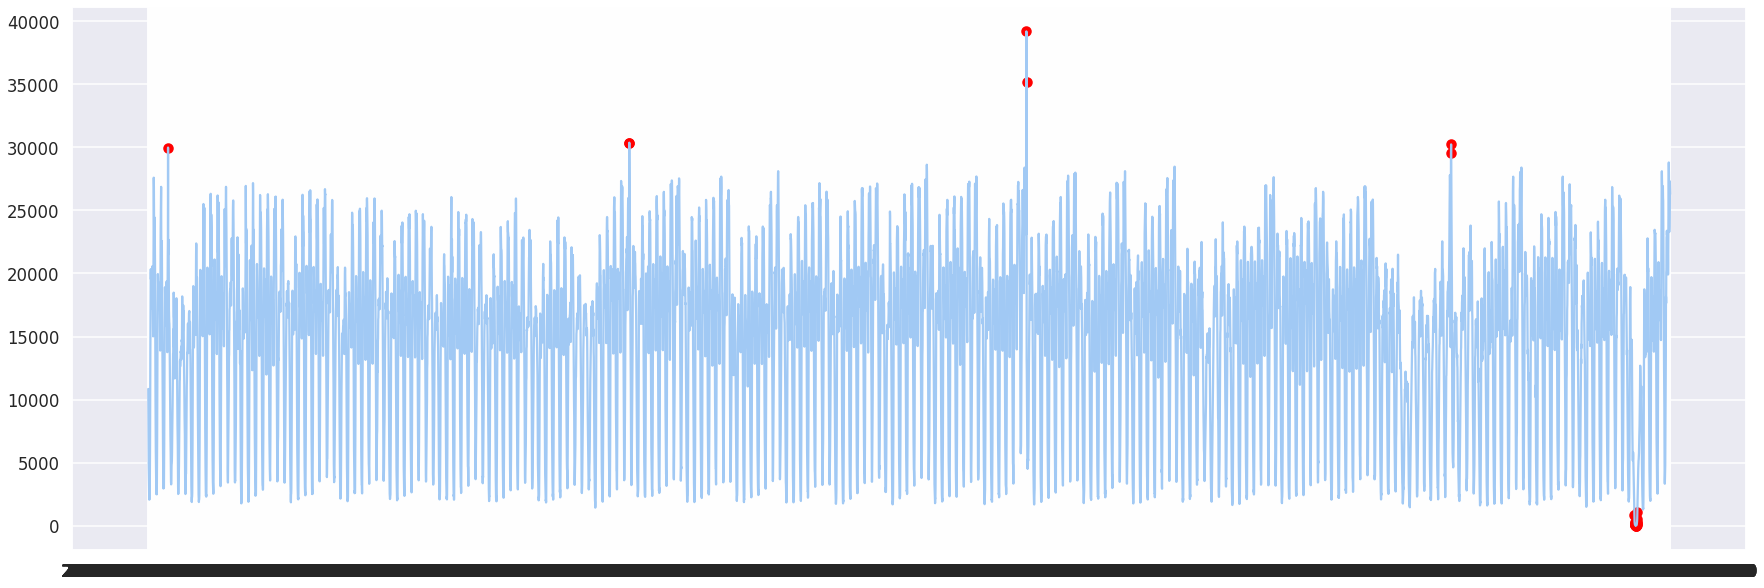

In [15]:
a = df.loc[df['anomaly_zscore'] == 1, ['timestamp', 'value']] 

plt.figure(figsize=(30, 10))

plt.plot(df['timestamp'], df['value'])
plt.scatter(a['timestamp'], a['value'], color='red')
plt.show()

## **Interquartile Range**

In [16]:
def out_iqr(df):
  global lower,upper, anomalies
  anomalies = []
  #q25, q75 = np.quantile(df['value'], 0.25), np.quantile(df['value'], 0.75)
  q25 = df['value'].quantile(0.25)
  q75 = df['value'].quantile(0.75)
  # calculate the IQR
  iqr = q75 - q25
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  # calculate the lower and upper bound value
  lower, upper = q25 - cut_off, q75 + cut_off
  print('The IQR is',iqr)
  print('The lower bound value is', lower)
  print('The upper bound value is', upper)
  # Calculate the number of records below and above lower and above bound value respectively
  df1 = df[df['value'] > upper]
  df2 = df[df['value'] < lower]
  for index, row in df.iterrows():
    if row['value'] > upper or row['value'] < lower:
      anomalies.append(1)
    else:
      anomalies.append(0)
  return print('Total number of outliers are', df1.shape[0] + df2.shape[0])

In [17]:
out_iqr(df)

The IQR is 9576.75
The lower bound value is -4103.125
The upper bound value is 34203.875
Total number of outliers are 2


In [18]:
df['anomaly_iqr'] = anomalies

In [19]:
df.head()

,timestamp,value,anomaly_zscore,anomaly_iqr
0,2014-07-01 00:00:00,10844,0,0
1,2014-07-01 00:30:00,8127,0,0
2,2014-07-01 01:00:00,6210,0,0
3,2014-07-01 01:30:00,4656,0,0
4,2014-07-01 02:00:00,3820,0,0


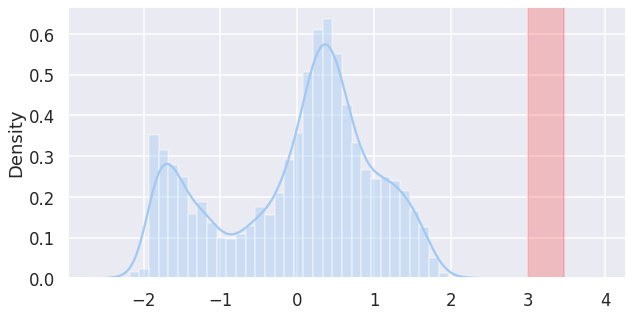

In [20]:
plt.figure(figsize = (10,5))
sns.distplot(zscores)
plt.axvspan(xmin = 3 ,xmax = max(zscores),alpha=0.2, color='red')

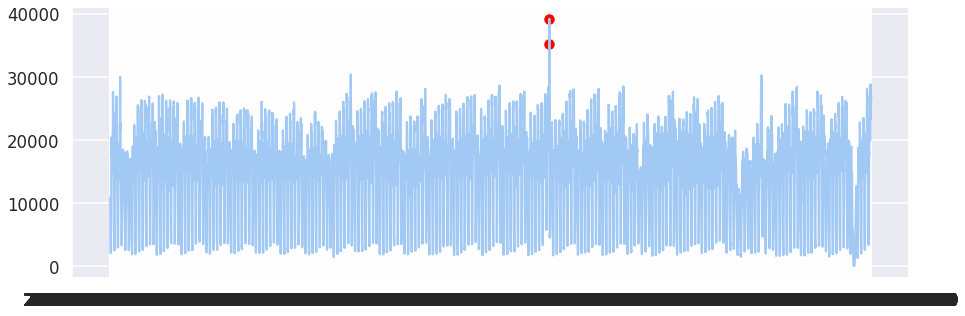

In [21]:
a = df.loc[df['anomaly_iqr'] == 1, ['timestamp', 'value']] 

plt.figure(figsize=(15, 5))

plt.plot(df['timestamp'], df['value'])
plt.scatter(a['timestamp'], a['value'], color='red')
plt.show()

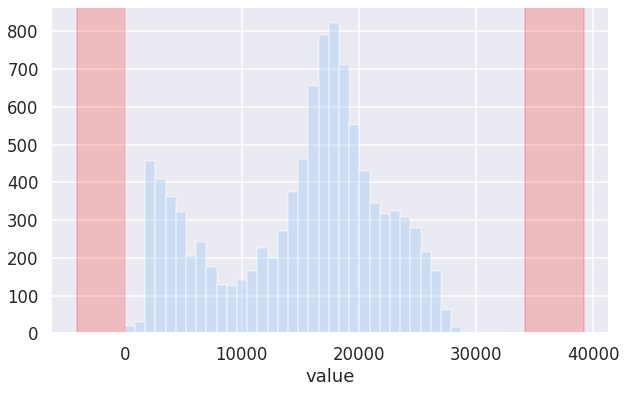

In [22]:
plt.figure(figsize = (10,6))
sns.distplot(df.value, kde=False)
plt.axvspan(xmin = lower,xmax= df.value.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df.value.max(),alpha=0.2, color='red')

## **Isolation Forest**

In [23]:
# train isolation forest 
data = df['value'].values.reshape(-1, 1)
outliers_fraction = 0.005
model =  IsolationForest(contamination = outliers_fraction, random_state=np.random.RandomState(43))
model.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.005,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7FCE2522E8D0, verbose=0,
                warm_start=False)

In [24]:
# add the data to the main  
df['anomaly_if'] = pd.Series(model.predict(data))
df['anomaly_if'] = df['anomaly_if'].map( {1: 0, -1: 1} )
print(df['anomaly_if'].value_counts())

0    10268
1       52
Name: anomaly_if, dtype: int64


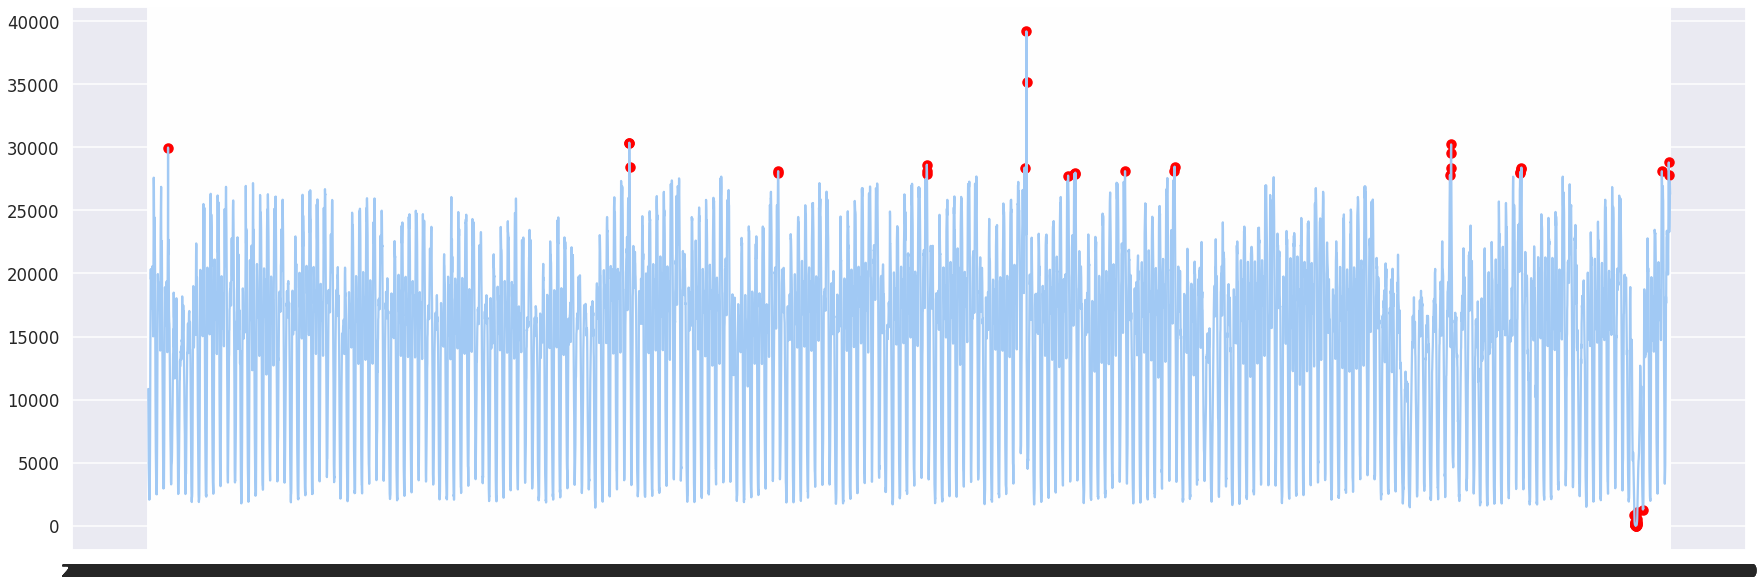

In [25]:
a = df.loc[df['anomaly_if'] == 1, ['timestamp', 'value']] 

plt.figure(figsize=(30, 10))

plt.plot(df['timestamp'], df['value'])
plt.scatter(a['timestamp'], a['value'], color='red')
plt.show()

## **DBSCAN**

In [26]:
!gdown --id 1dwSQfkugQjEMNa3pZwrXdhwmkKgcMFhK

Downloading...
From: https://drive.google.com/uc?id=1dwSQfkugQjEMNa3pZwrXdhwmkKgcMFhK
To: /content/insurance.csv
100% 55.6k/55.6k [00:00<00:00, 52.1MB/s]


In [32]:
df = pd.read_csv('insurance.csv')

In [33]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [34]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [35]:
X = df[['age','bmi']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

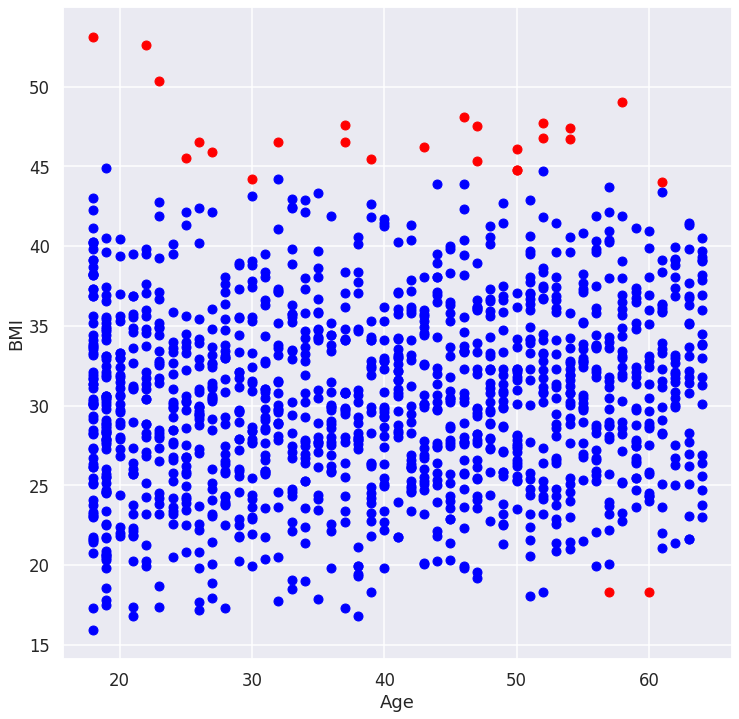

In [36]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');